In [1]:
import nimblephysics as nimble
import numpy as np
import torch

import time

from IPython.core.display_functions import clear_output
from einops import einsum, repeat
from scipy.ndimage import median_filter
from tqdm import tqdm

import theseus as th

import os
import pickle

In [2]:
trial_path = "/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/DIP/S1.b3d"
GEOMETRY_PATH = "/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/Geometry/"
GRAVITY = 9.80665

In [3]:
from typing import List, Tuple

subject = nimble.biomechanics.SubjectOnDisk(trial_path)
skeleton = nimble.dynamics.Skeleton = subject.readSkel(processingPass=1,
                                                       geometryFolder=GEOMETRY_PATH)

skel_joints = [skeleton.getJoint(i).getName() for i in range(skeleton.getNumJoints())]
skel_body_nodes = [skeleton.getBodyNode(i).getName() for i in range(skeleton.getNumBodyNodes())]

print(len(skel_body_nodes))
skel_body_nodes

Setting len to 0.106608
Setting neutral pos to   0
0.7
  0
24
Setting len to 0.342794
Setting neutral pos to    0
-0.6
   0
Setting len to 0.119716
Setting neutral pos to   0
0.2
  0


['pelvis',
 'femur_r',
 'tibia_r',
 'talus_r',
 'calcn_r',
 'toes_r',
 'femur_l',
 'tibia_l',
 'talus_l',
 'calcn_l',
 'toes_l',
 'lumbar_body',
 'thorax',
 'head',
 'scapula_r',
 'humerus_r',
 'ulna_r',
 'radius_r',
 'hand_r',
 'scapula_l',
 'humerus_l',
 'ulna_l',
 'radius_l',
 'hand_l']

In [4]:
print(len(skel_joints))
skel_joints

24


['ground_pelvis',
 'hip_r',
 'walker_knee_r',
 'ankle_r',
 'subtalar_r',
 'mtp_r',
 'hip_l',
 'walker_knee_l',
 'ankle_l',
 'subtalar_l',
 'mtp_l',
 'lumbar',
 'thoracic_spine',
 'neck',
 'scapulothoracic_r',
 'GlenoHumeral_r',
 'elbow_r',
 'radioulnar_r',
 'wrist_r',
 'scapulothoracic_l',
 'GlenoHumeral_l',
 'elbow_l',
 'radioulnar_l',
 'wrist_l']

In [5]:
skeleton.getNumDofs()

49

In [6]:
right_wrist: nimble.dynamics.Joint = skeleton.getBodyNode("hand_r")
translation: np.ndarray = np.array([0.0, 0.05, 0.0])
rotation: np.ndarray = np.eye(3)
watch_offset: nimble.math.Isometry3 = nimble.math.Isometry3(rotation, translation)

skeleton.setGravity(np.array([0.0, -GRAVITY, 0.0]))

print(skeleton.getBodyNode("hand_r").getWorldTransform())

[[ 0.8503932  -0.28173527  0.44436094  0.07124618]
 [ 0.26341593  0.95906446  0.10395866  0.88399438]
 [-0.4554596   0.02864602  0.88979546  0.18382312]
 [ 0.          0.          0.          1.        ]]


In [7]:
import matplotlib.pyplot as plt

def minimize(sequence):
    smooth_weight = 0.36
    regularization_weight = 0.1
    lr = 2
    iterations = 10000
    device = "cuda" if torch.cuda.is_available() else "cpu"

    orig_sequence = torch.from_numpy(sequence).to(device=device)
    output_sequence = orig_sequence.detach().clone().requires_grad_(True)

    optimizer = torch.optim.SGD([output_sequence], lr=lr)

    def loss():
        return smooth_weight * torch.square(output_sequence - orig_sequence).sum() + regularization_weight * torch.square(output_sequence).sum()

    for i in range(iterations):
        optimizer.zero_grad()
        loss_val = loss()
        loss_val.backward()
        optimizer.step()

    return output_sequence.detach().cpu().numpy()

In [8]:
def fill_nans(acc: torch.Tensor) -> torch.Tensor:
    # Reshape (T, N, C) -> (T, N*C) for simpler 1D column-wise interpolation
    T, N, C = acc.shape
    acc_2d = acc.reshape(T, N * C)

    # Move to CPU (if on GPU) for NumPy ops
    acc_np = acc_2d

    for col_idx in range(acc_np.shape[1]):
        col_data = acc_np[:, col_idx]
        # Find indices of valid and invalid entries
        valid_mask = ~np.isnan(col_data)
        if not np.any(valid_mask):
            # All NaNs; decide how to fill them (zero or remain NaN)
            # Here we choose to fill with zero for demonstration:
            col_data[:] = 0.0
            continue
        if np.all(valid_mask):
            # Already has no NaNs in this column
            continue

        valid_x = np.where(valid_mask)[0]
        valid_y = col_data[valid_mask]
        invalid_x = np.where(~valid_mask)[0]

        # Interpolate
        col_data[invalid_x] = np.interp(invalid_x, valid_x, valid_y)

    # Move back to original device
    acc_filled = acc_np.reshape(T, N, C)
    return acc_filled

In [9]:
with open("/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/DIP/DIP_orig/S1/01.pkl", "rb") as file:
    vals = pickle.load(file, encoding="latin1")["imu"]

vals[:, :, :3]

array([[[ 0.89995843, -0.15217061, -0.40855714],
        [ 0.98648638, -0.01189452,  0.16341096],
        [        nan,         nan,         nan],
        ...,
        [-0.14920152, -0.95913027,  0.240433  ],
        [ 0.97157289,  0.08987311,  0.21901815],
        [        nan,         nan,         nan]],

       [[ 0.90291665, -0.15042667, -0.402633  ],
        [ 0.98649444, -0.01166408,  0.16337893],
        [ 0.98324461,  0.00484152,  0.18222677],
        ...,
        [-0.14931078, -0.95916191,  0.2402389 ],
        [ 0.97160456,  0.08989438,  0.21886885],
        [ 0.94187588,  0.02695563,  0.33487791]],

       [[ 0.90710633, -0.14777461, -0.39410756],
        [ 0.98643782, -0.01152577,  0.1637302 ],
        [ 0.98329519,  0.00478607,  0.18195509],
        ...,
        [-0.14962804, -0.95967677,  0.23797469],
        [ 0.97161546,  0.09008362,  0.21874263],
        [ 0.94187571,  0.02695153,  0.33487874]],

       ...,

       [[ 0.91603171,  0.03686403,  0.39940824],
        [ 0

In [10]:
from scipy import signal
from scipy.ndimage import uniform_filter1d
from scipy.spatial.transform import Rotation

import torch


class DIP_Subject:
    def __init__(self, b3d_path):
        self.subject = nimble.biomechanics.SubjectOnDisk(b3d_path)
        self.skeleton = self.subject.readSkel(processingPass=1, geometryFolder=GEOMETRY_PATH)
        self.subject_num = int(b3d_path.split("/")[-1].split(".")[0][1:])
        self.synthetic_component_names = [
            "head",
            "sternum",
            "pelvis",
            "lshoulder",
            "rshoulder",
            "lupperarm",
            "rupperarm",
            "llowerarm",
            "rlowerarm",
            "lupperleg",
            "rupperleg",
            "llowerleg",
            "rlowerleg",
            "lhand",
            "rhand",
            "lfoot",
            "rfoot",
        ]

        # Corresponding bones to the sensors
        self.skel_names = [
            "head",
            "thorax",
            "pelvis",
            "scapula_l",
            "scapula_r",
            "humerus_l",
            "humerus_r",
            "ulna_l",
            "ulna_r",
            "femur_l",
            "femur_r",
            "tibia_l",
            "tibia_r",
            "hand_l",
            "hand_r",
            "calcn_l",
            "calcn_r"
        ]

        self.N_MEAS = len(self.skel_names) * 3

        self.imus = [(self.skeleton.getBodyNode(name), nimble.math.Isometry3.Identity()) for name in self.skel_names]

        self.corresponding_imu_path = os.path.join(os.path.dirname(b3d_path), f"DIP_orig/S{self.subject_num}")
        self.trial_map = {}
        self.joint_data_map = {}
        self.trial_imu_map = {}
        # self.skeleton.setGravity([0, -GRAVITY, 0])
        self.skeleton.setGravity([0, 0, 0])
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print(f"Processing DIP Subject {self.subject_num}")


        # Creating a map between a trial for some subject and the corresponding frame list
        for i in range(self.subject.getNumTrials()):
            key = self.subject.getTrialOriginalName(i).split("_")[0]
            curr_trial = self.subject.readFrames(trial=i,
                                                 startFrame=0,
                                                 numFramesToRead=self.subject.getTrialLength(i),
                                                 includeProcessingPasses=True)

            if key in self.trial_map:
                self.trial_map[key].extend(curr_trial)
            else:
                self.trial_map[key] = curr_trial

        # Define Butterworth filter parameters
        self.fs = 60  # Sampling frequency
        self.cutoff =  8  # Cutoff frequency
        self.b, self.a = signal.butter(10, self.cutoff / (self.fs / 2), btype='low')

        # Creating a map for joint state
        for key, frames in self.trial_map.items():
            joint_angles_raw = np.vstack([frame.processingPasses[0].pos for frame in frames]).T
            joint_vel_raw = np.vstack([frame.processingPasses[0].vel for frame in frames]).T
            joint_acc_raw = np.vstack([frame.processingPasses[0].acc for frame in frames]).T

            """
            self.joint_data_map[key] = {
                "joint_angles": signal.filtfilt(self.b, self.a, joint_angles_raw, axis=1),
                "joint_vel": signal.filtfilt(self.b, self.a, joint_vel_raw, axis=1),
                "joint_acc": signal.filtfilt(self.b, self.a, joint_acc_raw, axis=1),
            }
            """

            self.filter = (1, 8)
            self.joint_data_map[key] = {
                "joint_angles": joint_angles_raw,
                "joint_vel": uniform_filter1d(median_filter(joint_vel_raw, size=self.filter), size=100, axis=1),
                "joint_acc": uniform_filter1d(median_filter(joint_acc_raw, size=self.filter), size=100, axis=1),
            }


            with open(os.path.join(self.corresponding_imu_path, f"{key}.pkl"), "rb") as file:
                real_data = pickle.load(file, encoding="latin1")["imu"]
                acc = real_data[:, :, 9:12]
                acc = fill_nans(acc)

            self.num_trials = len(self.joint_data_map.keys())

            self.synthetic_transformations = {}
            self.gravity_translation = {}
            self.gravity_transformation = {}

            self.trial_imu_map[key] = {
                "acc": acc,
            }

        self.syn_imu = {}
        self.get_syn_imu_to_real_transformations()

        self.opt_trans = {}
        self.find_optimal_syn_transformations()

        gui = nimble.NimbleGUI()
        gui.serve(8080)

        transform_dict = self.opt_trans["03"]

        for t in tqdm(range(self.joint_data_map["03"]["joint_angles"].shape[1])):
            skeleton.setPositions(self.joint_data_map["03"]["joint_angles"][:, t])

            # Shape: (Sequence Length) x (IMUs) x (Rows) x (Cols)
            body_node_in_world = transform_dict["world_to_body_node"]

            # Shape: (IMUs) x (Rows) x (Cols)
            imu_in_body_node = transform_dict["body_node_to_imu"]

            # Grab the heads
            body_node_in_world = body_node_in_world[t, 0, :, :]
            imu_in_body_node = imu_in_body_node[0, :, :]

            imu_in_world_frame = imu_in_body_node @ body_node_in_world

            # gui.nativeAPI().renderBasis(prefix="transform_basis" ,scale=20000, pos=imu_in_world_frame[:-1, -1], euler=Rotation.from_matrix(imu_in_world_frame[:-1, :-1]).as_euler('zyx'))
            gui.nativeAPI().createBox(key="box", size=np.array([0.025,0.025,0.005]), pos=imu_in_world_frame[:-1, -1], euler=Rotation.from_matrix(imu_in_world_frame[:-1, :-1]).as_euler('zyx'), color=np.array([1, 0, 0, 1]))
            gui.nativeAPI().createBox(key="box_body_node", size=np.array([0.025,0.025,0.005]), pos=body_node_in_world[:-1, -1], euler=Rotation.from_matrix(body_node_in_world[:-1, :-1]).as_euler('zyx'), color=np.array([1, 1, 0, 1]))
            # gui.nativeAPI().renderBasis(pos=body_node_in_world[:-1, -1], euler=Rotation.from_matrix(body_node_in_world[:-1, :-1]).as_euler('xyz'))
            # gui.nativeAPI().renderBasis()
            # gui.nativeAPI().renderArrow(start_pos, (gravity_direction / 10), 0.01, 0.04)

            # print(gravity_direction)
            gui.nativeAPI().renderSkeleton(skeleton)
            time.sleep(1/60)


    # Get estimated homogenous transformations from synthetix to real imu
    def get_syn_imu_to_real_transformations(self):
        for trial_name, trial in self.joint_data_map.items():
            joint_angles = trial["joint_angles"]
            joint_vel = trial["joint_vel"]
            joint_acc = trial["joint_acc"]

            curr_syn_acc = np.empty((self.N_MEAS,  joint_angles.shape[1]))
            curr_syn_angular_vel = np.empty((self.N_MEAS,  joint_angles.shape[1]))

            for t in range(joint_angles.shape[1]):
                self.skeleton.setPositions(joint_angles[:, t])
                self.skeleton.setVelocities(joint_vel[:, t])
                self.skeleton.setAccelerations(joint_acc[:, t])

                curr_syn_acc[:, t] = self.skeleton.getAccelerometerReadings(self.imus)
                curr_syn_angular_vel[:, t] = self.skeleton.getGyroReadings(self.imus)


            curr_syn_acc = curr_syn_acc.T.reshape(-1, 17, 3)
            curr_syn_angular_vel = curr_syn_angular_vel.T.reshape(-1, 17, 3)

            for i in range(3):
                plt.figure(figsize=(8, 4))
                plt.plot(np.arange(curr_syn_acc.shape[0]), curr_syn_acc[:, 0, i], label=f"Element {i}")

                plt.xlabel("Time")
                plt.ylabel(f"Value (Depth {i})")
                plt.title(f"Time Series for Depth {i}")
                plt.legend()
                plt.grid()

                plt.show()


            self.syn_imu[trial_name] = {"acc": curr_syn_acc, "angular_vel": curr_syn_angular_vel}


    def get_world_transforms(self, trial_name):
        num_time_steps = self.joint_data_map[trial_name]["joint_angles"].shape[1]
        world_transform = np.empty((num_time_steps, 17, 4, 4))


        for t in range(num_time_steps):
            self.skeleton.setPositions(self.joint_data_map[trial_name]["joint_angles"][:, t])

            for idx, body_node_name in enumerate(self.skel_names):
                world_transform[t, idx, :, :] = self.skeleton.getBodyNode(body_node_name).getWorldTransform().matrix()

        return world_transform

    def find_optimal_syn_transformations(self):
        for trial_name, syn_imu in self.syn_imu.items():
            # Convert numpy arrays to PyTorch tensors
            num_t_steps = syn_imu["acc"].shape[0]
            losses = []

            real_imu_data = torch.tensor(self.trial_imu_map[trial_name]["acc"], device=self.device, dtype=torch.float32)
            syn_imu_data = torch.tensor(np.concatenate((syn_imu["acc"], np.ones((num_t_steps, 17, 1))), axis=-1), device=self.device, dtype=torch.float32)
            trial_body_node_world_transforms = torch.tensor(self.get_world_transforms(trial_name), device=self.device, dtype=torch.float32)


            accel_translation_mat = torch.rand(17, 3, dtype=torch.float32, device=self.device).requires_grad_()
            unnormed_quaternions = torch.rand(17, 4, dtype=torch.float32, device=self.device).requires_grad_()

            optimizer = torch.optim.AdamW([
                                        {'params': [accel_translation_mat], 'weight_decay': 10},
                                        {'params': [unnormed_quaternions], 'weight_decay': 0}
            ], lr=1e-2)


            for iteration in range(700):
                optimizer.zero_grad()

                current_quaternions = unnormed_quaternions / torch.norm(unnormed_quaternions, dim=-1, keepdim=True)

                transforms = th.SE3(x_y_z_quaternion=torch.cat([accel_translation_mat, current_quaternions], dim=-1)).to_matrix()

                # transformed_syn = einsum(transforms, trial_body_node_world_transforms, syn_imu_data,
                #                          "imu c r, seq imu c r, seq imu r -> seq imu r")


                transformed_syn = einsum(trial_body_node_world_transforms, syn_imu_data, "seq imu i j, seq imu j -> seq imu i")
                transformed_syn = einsum(transforms, transformed_syn, "imu i j, seq imu i -> seq imu j")

                residual = real_imu_data - transformed_syn[:, :, :-1]
                loss = torch.norm(residual, p=2, dim=-1).mean()

                losses.append(loss.item())
                loss.backward()
                optimizer.step()


            current_quaternions = unnormed_quaternions / torch.norm(unnormed_quaternions, dim=-1, keepdim=True)

            self.opt_trans[trial_name] = {
                "body_node_to_imu": th.SE3(x_y_z_quaternion=torch.cat([accel_translation_mat, current_quaternions], dim=-1), dtype=torch.float32).to_matrix().detach().cpu().numpy(),
                "world_to_body_node": trial_body_node_world_transforms.detach().cpu().numpy(),
                "losses": losses
            }

            plt.figure(figsize=(8, 5))
            plt.plot(np.arange(len(losses)), losses, label="Training Loss", marker="o", linestyle="-", markersize=4)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Loss vs. Epochs")
            plt.legend()
            plt.grid(True)
            plt.show()

Processing DIP Subject 1Setting len to 0.106608
Setting neutral pos to   0
0.7
  0
Setting len to 0.342794
Setting neutral pos to    0
-0.6
   0
Setting len to 0.119716
Setting neutral pos to   0
0.2
  0



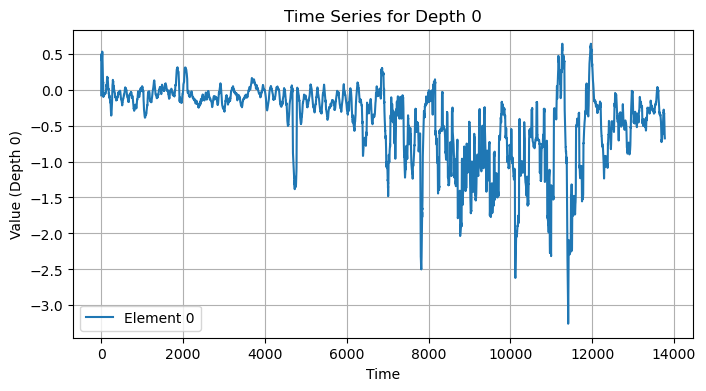

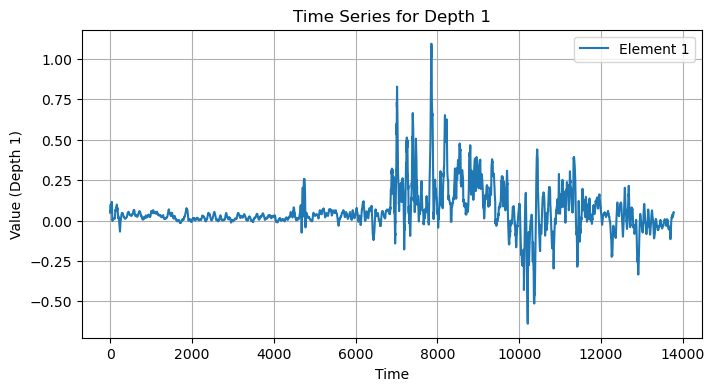

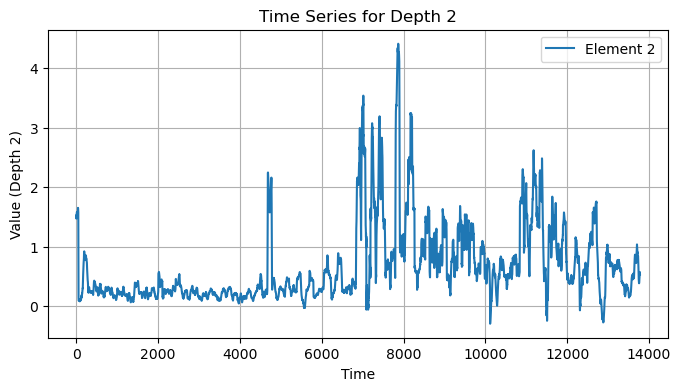

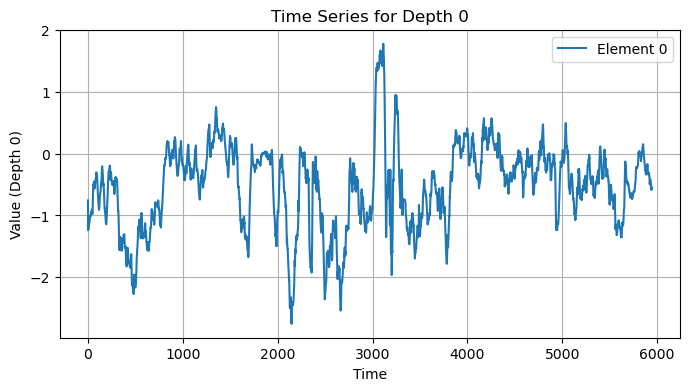

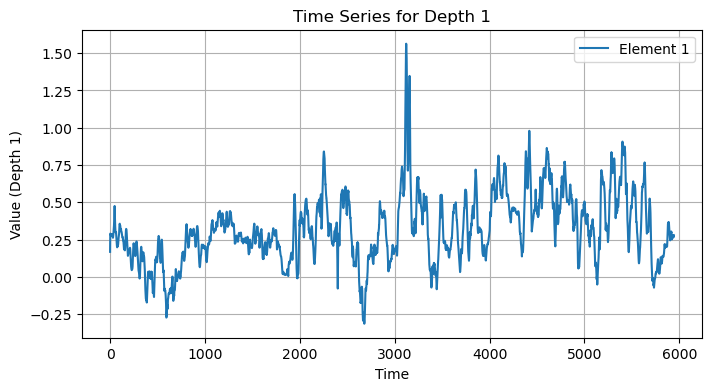

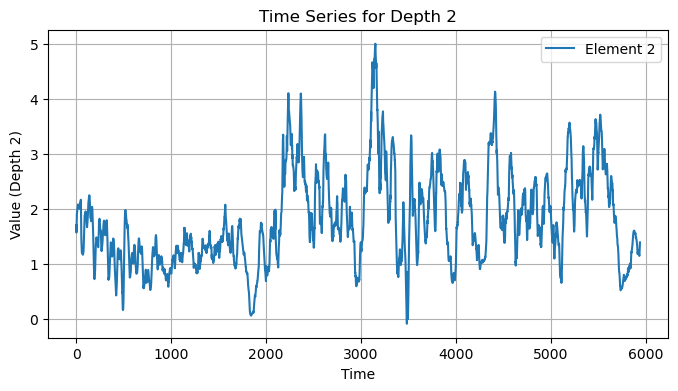

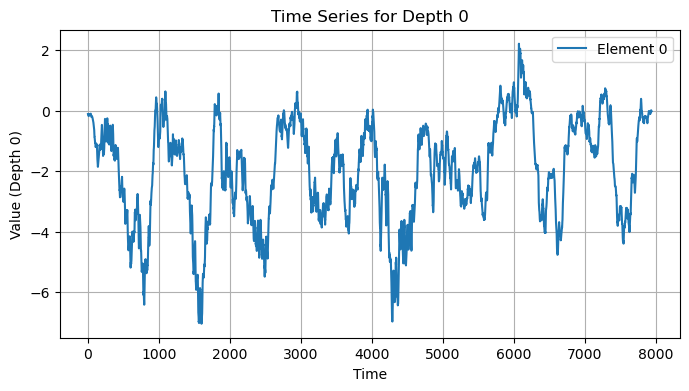

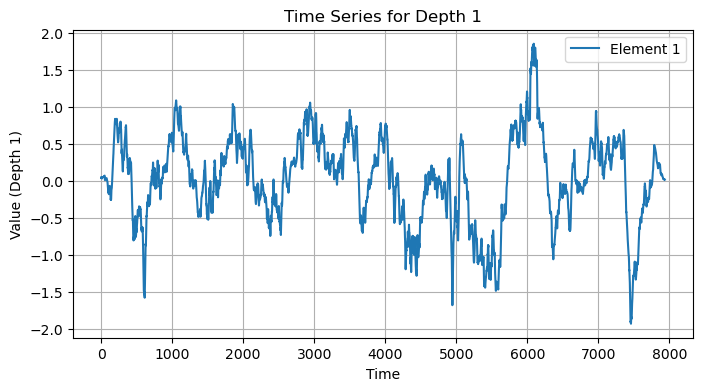

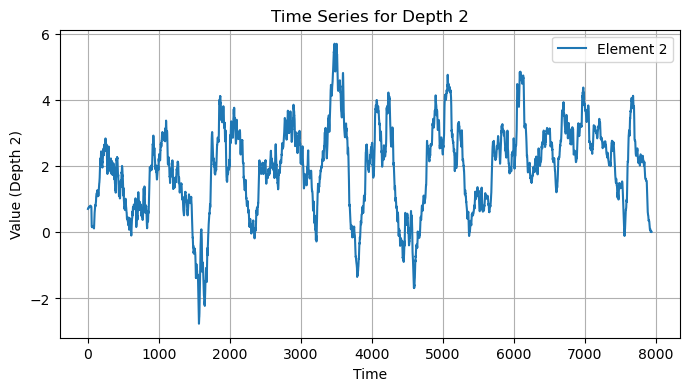

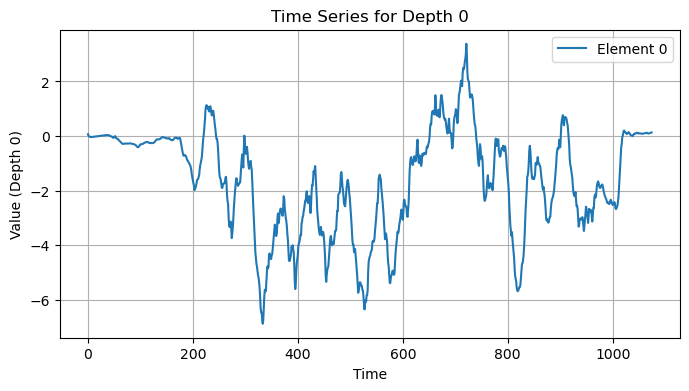

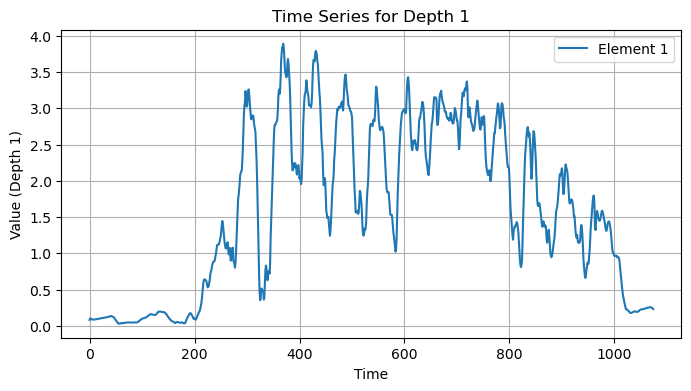

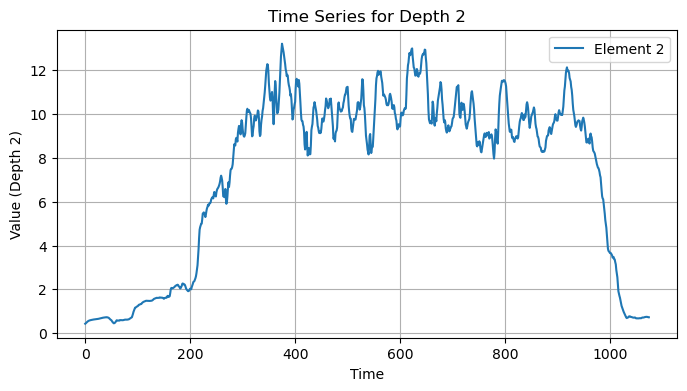

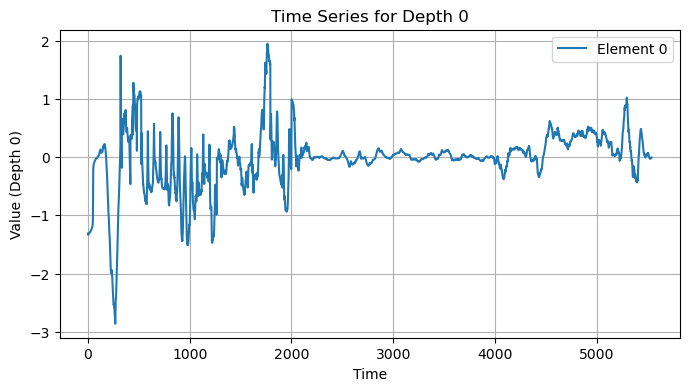

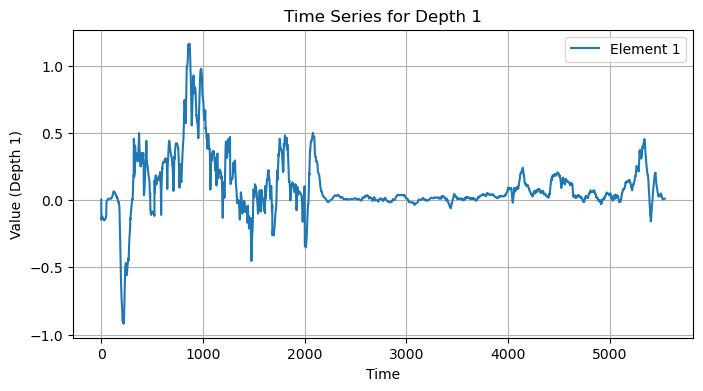

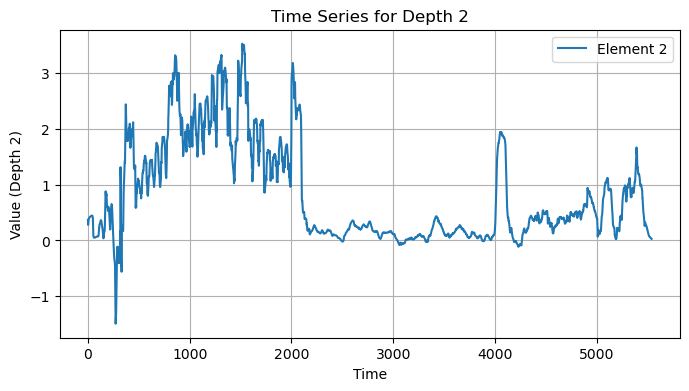

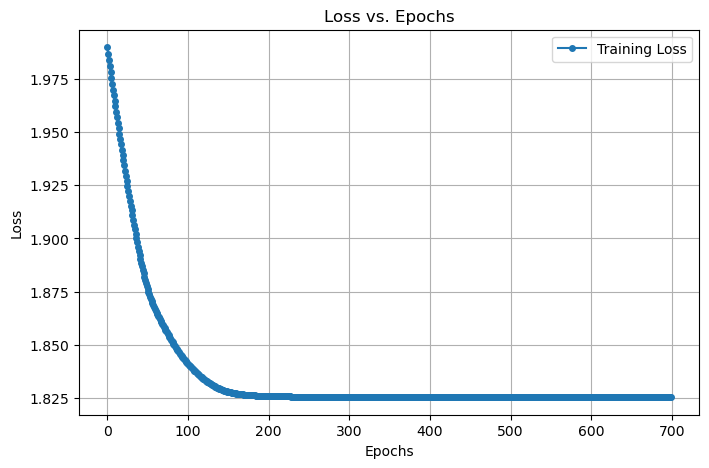

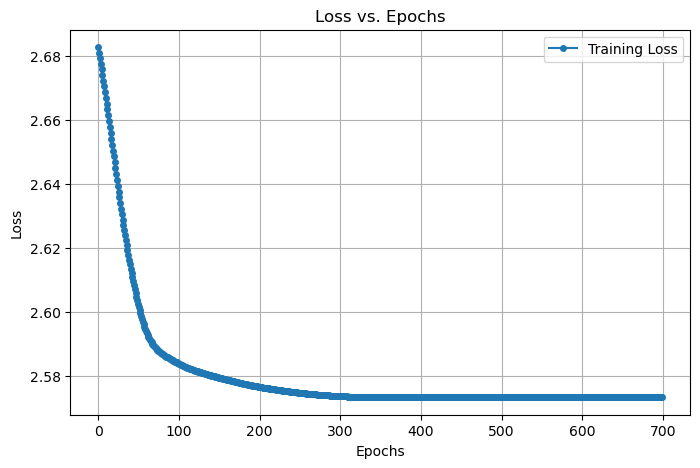

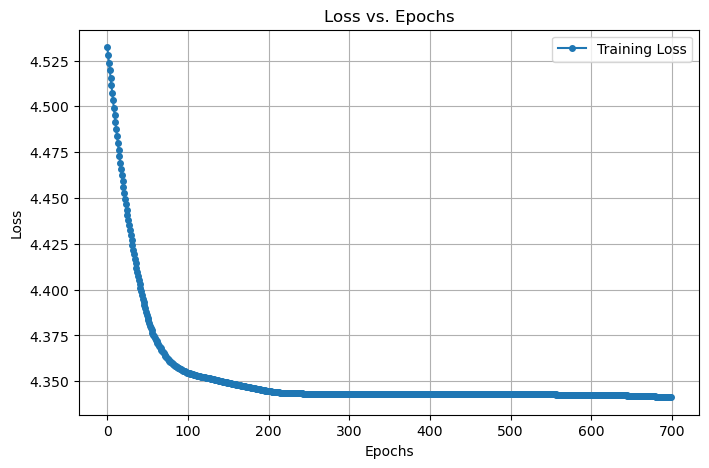

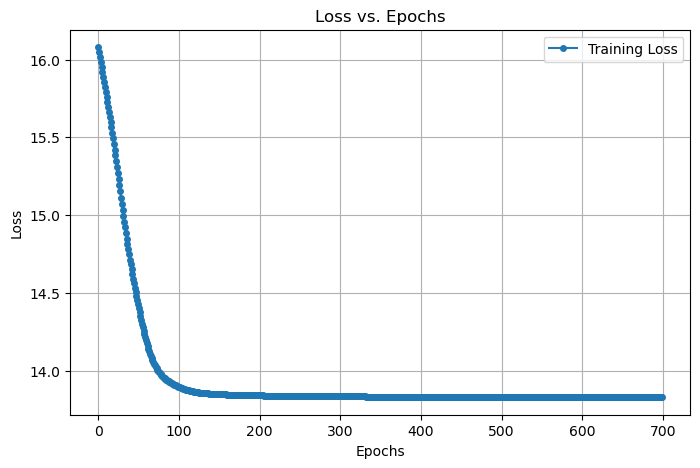

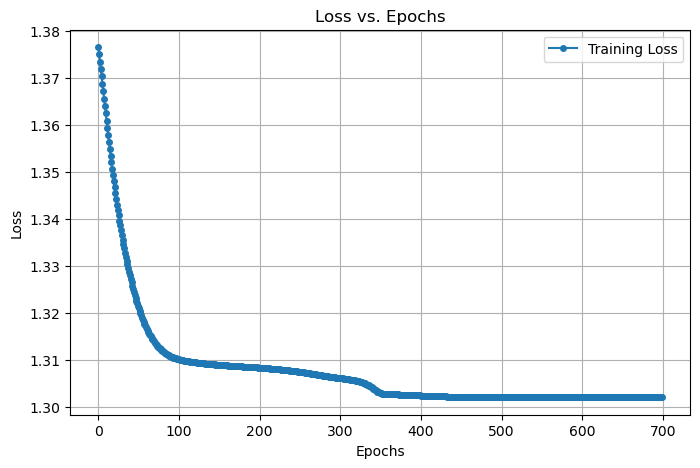

GUIWebsocketServer will start serving a WebSocket server on ws://localhost:8070
Web GUI serving on http://localhost:8080


100%|██████████| 7938/7938 [02:15<00:00, 58.62it/s]

GUIWebsocketServer is shutting down the WebSocket server on ws://localhost:8070



Error [GUIWebsocketServer.cpp:45] GUIWebsocketServer is being deallocated while it's still serving! The server will now terminate, and attempt to clean up. If this was not intended behavior, please keep a reference to the GUIWebsocketServer to keep the server alive. If this was intended behavior, please call stopServing() on the server before deallocating it.


In [11]:
dip_subject = DIP_Subject(trial_path)

In [12]:
import pickle
with open("/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/DIP/DIP_orig/S1/01.pkl", "rb") as file:
    loaded_dict = pickle.load(file, encoding="latin1")

loaded_dict.keys()

dict_keys(['gt', 'imu_acc', 'sop', 'sip', 'imu', 'imu_ori'])

In [13]:
loaded_dict['gt'].shape

(13778, 72)

In [14]:
loaded_dict["imu"].shape

(13778, 17, 12)

In [15]:
loaded_dict["imu_acc"].shape

(13778, 17, 3)